In [2]:
import sys

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn.metrics as skm 
import os.path
import dask
from distributed import Client, progress
import dask.async
import dask.diagnostics
import itertools

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

# Gini Parameter Grid Search
In this document we use grid search to 

* find optimal parameters for the gini method
* test the robustness of the method over different parameters. 

### Again, we use dask for parallel computing:

In [3]:
c = Client("10.114.185.14:8786")

In [4]:
n_splits = 10
expr_file = "../data/gtex/exprs.npy"
target_file = "../data/gtex/target.csv"
splitter = sklearn.model_selection.StratifiedKFold(n_splits)
signature_generator = GiniSignatureGenerator
signature_tester = BioQCSignatureTester

In [78]:
gini_list = [0.7, 0.75, 0.8, 0.85, 0.9, 0.92, 0.95]
rk_list =  [1, 2, 3, 4, 5, 6, 7, 10][:]

In [87]:
def reshape(array):
    return np.reshape(array, (len(gini_list), len(rk_list)))

The code performing the grid search: 

In [80]:
grid_ind = []
grid_sig = []
grid_cm =  []
for i, min_gini in enumerate(gini_list):
    for j, max_rk in enumerate(rk_list):
        sig_list, res_list = cross_validate_signatures(
            expr_file,
            target_file,
            signature_generator,
            signature_tester,
            splitter,
            sg_kwargs={"min_gini": min_gini, "max_rk": max_rk})
        grid_ind.append((min_gini, max_rk))
        grid_sig.append(sig_list)
        grid_cm.append(res_list)

Doing the actual computation: 

In [81]:
futures = c.compute(grid_sig + grid_cm, sync=False)

In [82]:
progress(futures)

In [83]:
grid_sig_res = [f.result() for f in futures[:len(gini_list) * len(rk_list)]]
grid_cm_res = [f.result() for f in futures[len(gini_list) * len(rk_list):]]

## Signature overlap between the folds

In [84]:
pairwise_jaccard = []
for signatures in grid_sig_res:
    pwj = pairwise_jaccard_ind(signatures)
    pwj = {sig: np.mean(jacc) for sig, jacc in pwj.items()}
    pairwise_jaccard.append(pwj)

/pstore/home/sturmg/projects/gene-set-study/pygenesig/tools.py:47: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(i, u)


In [85]:
pairwise_jaccard_mean = [np.mean(list(iter(per_tissue.values()))) for per_tissue in pairwise_jaccard]

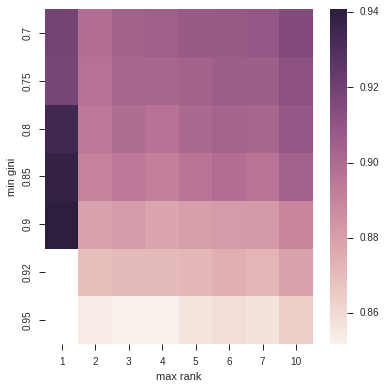

In [89]:
fig, ax = subplots(figsize=(6, 6))
sns.heatmap(reshape(pairwise_jaccard_mean), xticklabels=rk_list, yticklabels=gini_list, ax=ax)
ax.set_xlabel("max rank")
ax.set_ylabel("min gini")

## Overall Performance
The following heatmaps show the average Sensitiviy, Specificity and Matthews correlation over all tissues. 

In [92]:
mcc_per_tissue = []
sens_per_tissue = []
spec_per_tissue = []
for signatures, cms in zip(grid_sig_res, grid_cm_res):
    sig_labels = BioQCSignatureTester.sort_signatures(signatures[0])
    mcc_per_tissue.append(performance_per_tissue(cms, sig_labels, pm.mcc))
    sens_per_tissue.append(performance_per_tissue(cms, sig_labels, pm.sens))
    spec_per_tissue.append(performance_per_tissue(cms, sig_labels, pm.spec))

/pstore/home/sturmg/projects/gene-set-study/pygenesig/perfmeasures.py:6: RuntimeWarning: invalid value encountered in true_divide
  return np.divide(TP * TN + FP * FN, sqrt((TP+FP) * (TP+FN) * (TN+FP) * (TN+FN)))


In [93]:
mcc_mean = [np.mean(list(iter(per_tissue.values()))) for per_tissue in mcc_per_tissue]
sens_mean = [np.mean(list(iter(per_tissue.values()))) for per_tissue in sens_per_tissue]
spec_mean = [np.mean(list(iter(per_tissue.values()))) for per_tissue in spec_per_tissue]

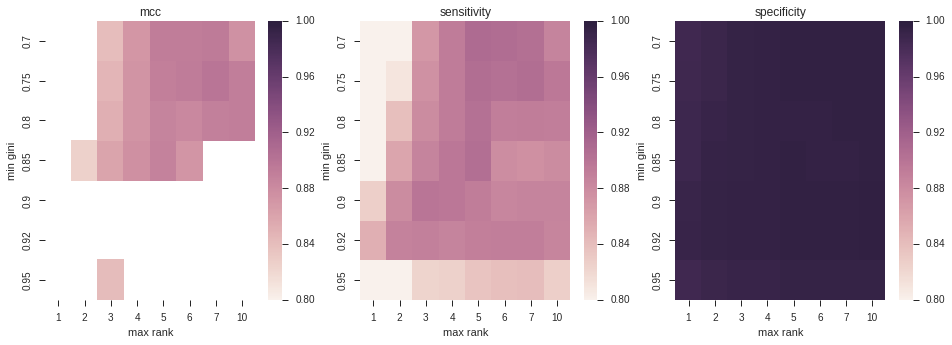

In [95]:
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(16, 5))
sns.heatmap(reshape(mcc_mean), xticklabels=rk_list, yticklabels=gini_list, ax=ax1, vmin=.8, vmax=1.)
ax1.set_title("mcc")
sns.heatmap(reshape(sens_mean), xticklabels=rk_list, yticklabels=gini_list, ax=ax2, vmin=.8, vmax=1.)
ax2.set_title("sensitivity")
sns.heatmap(reshape(spec_mean), xticklabels=rk_list, yticklabels=gini_list, ax=ax3, vmin=.8, vmax=1.)
ax3.set_title("specificity")
for ax in (ax1, ax2, ax3):
    ax.set_xlabel("max rank")
    ax.set_ylabel("min gini")

## By Tissue

[[<matplotlib.axes._subplots.AxesSubplot object at 0x2aabbf2be160>


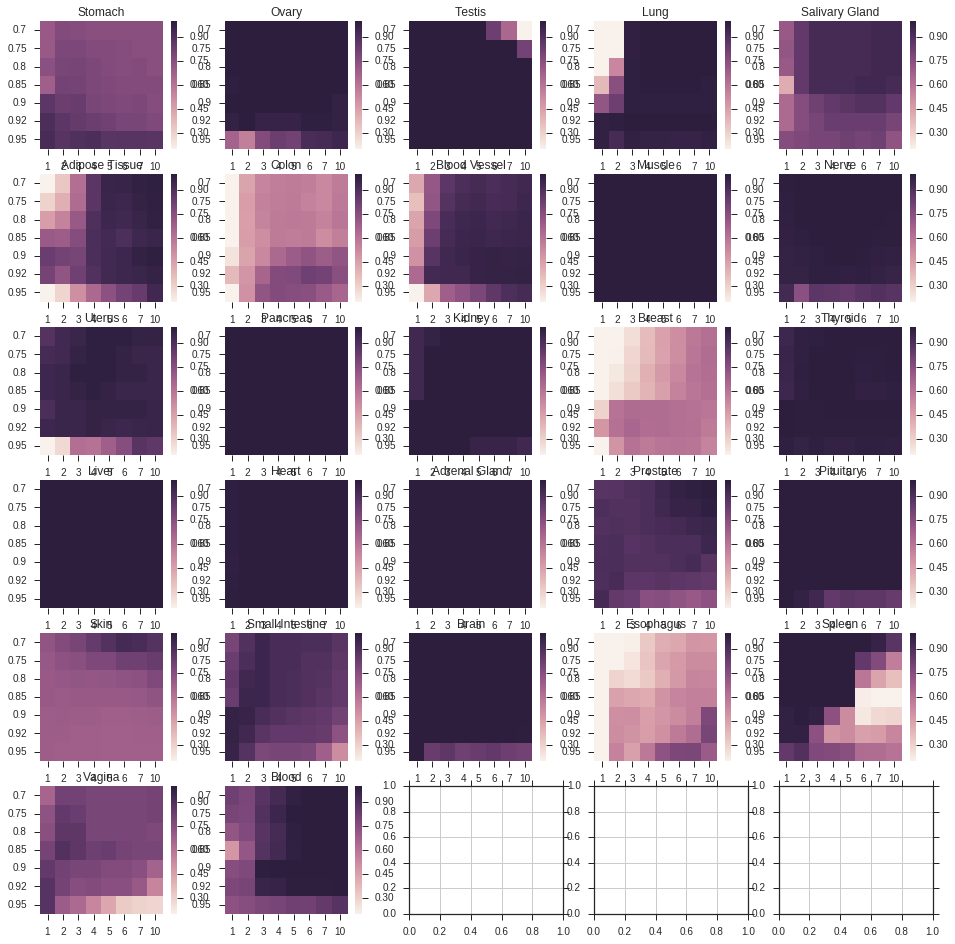

In [98]:
fig, ax = subplots(6, 5, figsize=(16, 16));
print(ax)
for i, tissue in enumerate(mcc_per_tissue[0]):
    j = i % 5
    i = i // 5
    per_tissue = np.array([np.mean(mcc[tissue]) for mcc in sens_per_tissue])
    sns.heatmap(reshape(per_tissue), ax=ax[i,j], xticklabels=rk_list, yticklabels=gini_list, vmin=.2, vmax=1);
    ax[i, j].set_title(tissue);